In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from itertools import product

# 1. Correctional Analysis
## 1.1 Collect historical data for NASDAQ and NSE indices.

In [2]:
# Define the tickers for NASDAQ and NSE indices
nasdaq_ticker = '^IXIC'
nse_ticker = '^NSEI'

# Set the start and end dates for the historical data
start_date = '2010-01-01'
end_date = '2023-06-04'

# Collect historical data for NASDAQ index
nasdaq_data = yf.download(nasdaq_ticker, start=start_date, end=end_date)

# Collect historical data for NSE index
nse_data = yf.download(nse_ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
nasdaq_data.shape

(3377, 6)

In [4]:
nse_data.shape

(3292, 6)

##  1.2 Calculate the correlation coefficient between the two indices.

In [5]:
# Select the common trading days
common_dates = nasdaq_data.index.intersection(nse_data.index)

# Filter the data for common trading days
nasdaq = nasdaq_data.loc[common_dates]
nse = nse_data.loc[common_dates]

In [6]:
# Calculate the correlation between the indices
correlation = nasdaq['Close'].corr(nse['Close'])

# Print the correlation value
print("Correlation between NASDAQ and NSE indices:", correlation)

Correlation between NASDAQ and NSE indices: 0.9512057035170748


## 1.3 Analyze the strength and direction of the relationship.

# 2. Lead-Lag Relationship
## 2.1 Identify potential lead-lag relationships between the indices.

In [7]:
# Perform lag analysis
lags = range(-15, 15)  # Define the range of lag periods
correlations = []

for lag in lags:
    nasdaq_shifted = nasdaq['Close'].shift(lag)
    correlation = nasdaq_shifted.corr(nse['Close'])
    correlations.append(correlation)

# Find the lag period with the maximum correlation
max_correlation = max(correlations)
max_lag = lags[correlations.index(max_correlation)]

## 2.2 Analyze data to determine consistent leading or lagging behavior.

In [8]:
# Identify consistent leading or lagging behavior
leading_indices = [i for i, corr in enumerate(correlations) if corr > 0.5]
lagging_indices = [i for i, corr in enumerate(correlations) if corr < -0.5]

## 2.3 Use the lead-lag relationship to determine the index to be used for parameter optimization.

In [9]:
# Determine the index for parameter optimization
if max_correlation > 0.5:
    optimization_index = nasdaq['Close'].shift(max_lag)
    optimization_index_name = "NASDAQ"
elif max_correlation < -0.5:
    optimization_index = nse['Close']
    optimization_index_name = "NSE"
else:
    optimization_index = None
    optimization_index_name = "No significant lead-lag relationship found"

In [10]:
# Print the results
print("Max Correlation:", max_correlation)
print("Max Lag Period:", max_lag)
print("Index for Parameter Optimization:", optimization_index_name)

Max Correlation: 0.9519196260560229
Max Lag Period: 9
Index for Parameter Optimization: NASDAQ


## 2.4 Provide an explanation for choosing the index for parameter optimization


# 3. Indicator Coding
## 3.1 Code Keltner Channel

In [11]:
import ta
# Calculate Keltner Channel
nasdaq_keltner_channel = ta.volatility.KeltnerChannel(high=nasdaq['High'], low=nasdaq['Low'], close=nasdaq['Close'], window=20, window_atr=10)
nse_keltner_channel = ta.volatility.KeltnerChannel(high=nse['High'], low=nse['Low'], close=nse['Close'], window=20, window_atr=10)

# Add Keltner Channel upper and lower bands to the DataFrame
nasdaq['KC_Upper'] = nasdaq_keltner_channel.keltner_channel_hband()
nasdaq['KC_Lower'] = nasdaq_keltner_channel.keltner_channel_lband()
nse['KC_Upper'] = nse_keltner_channel.keltner_channel_hband()
nse['KC_Lower'] = nse_keltner_channel.keltner_channel_lband()

## 3.2 Bollinger Bands

In [12]:
# Calculate Bollinger Bands
nasdaq_bollinger_bands = ta.volatility.BollingerBands(close=nasdaq['Close'], window=20, window_dev=2)
nse_bollinger_bands = ta.volatility.BollingerBands(close=nse['Close'], window=20, window_dev=2)

# Add Bollinger Bands upper, middle, and lower bands to the DataFrame
nasdaq['BB_Upper'] = nasdaq_bollinger_bands.bollinger_hband()
nasdaq['BB_Middle'] = nasdaq_bollinger_bands.bollinger_mavg()
nasdaq['BB_Lower'] = nasdaq_bollinger_bands.bollinger_lband()
nse['BB_Upper'] = nse_bollinger_bands.bollinger_hband()
nse['BB_Middle'] = nse_bollinger_bands.bollinger_mavg()
nse['BB_Lower'] = nse_bollinger_bands.bollinger_lband()

## 3.3 MACD indicators

In [13]:
# Calculate MACD
nasdaq_macd = ta.trend.MACD(close=nasdaq['Close'], window_slow=26, window_fast=12, window_sign=9)
nse_macd = ta.trend.MACD(close=nse['Close'], window_slow=26, window_fast=12, window_sign=9)

# Add MACD line, signal line, and histogram to the DataFrame
nasdaq['MACD_Line'] = nasdaq_macd.macd()
nasdaq['MACD_Signal_Line'] = nasdaq_macd.macd_signal()
nasdaq['MACD_Histogram'] = nasdaq_macd.macd_diff()
nse['MACD_Line'] = nse_macd.macd()
nse['MACD_Signal_Line'] = nse_macd.macd_signal()
nse['MACD_Histogram'] = nse_macd.macd_diff()

# 4. Parameter Optimisation
## 4.1 Optimize parameters for the indicators on one index
### Optimising Parameters for Keltner Channel

In [14]:
# Define parameter ranges to test
window_range = range(10, 31, 5)  # Example: 10, 15, 20, 25, 30
atr_range = range(5, 21, 5)  # Example: 5, 10, 15, 20

best_params = None
best_score = float('-inf')

# Perform grid search
for window, atr in product(window_range, atr_range):
    # Calculate Keltner Channel with current parameters
    nasdaq_keltner_channel = ta.volatility.KeltnerChannel(high=nasdaq['High'], low=nasdaq['Low'], close=nasdaq['Close'], window=window, window_atr=atr)

    # Extract upper and lower bands
    upper_band = nasdaq_keltner_channel.keltner_channel_hband()
    lower_band = nasdaq_keltner_channel.keltner_channel_lband()

    # Calculate a score for the current parameters (e.g., based on trading strategy performance)

    # Example: Calculate the average percentage of price above the upper band
    score = ((nasdaq['Close'] > upper_band).sum() / len(nasdaq)) * 100

    # Check if current parameters yield a better score
    if score > best_score:
        best_score = score
        best_params = (window, atr)

# Print the best parameters and corresponding score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: (30, 5)
Best Score: 54.0405616224649


### Optimising Parameters for Bollinger Bands

In [15]:
# Define parameter ranges to test
window_range = range(10, 31, 5)  # Example: 10, 15, 20, 25, 30
dev_range = range(1, 4)  # Example: 1, 2, 3

best_params = None
best_score = float('-inf')

# Perform grid search
for window, dev in product(window_range, dev_range):
    # Calculate Bollinger Bands with current parameters
    bollinger_bands = ta.volatility.BollingerBands(close=nasdaq['Close'], window=window, window_dev=dev)

    # Extract upper, middle, and lower bands
    upper_band = bollinger_bands.bollinger_hband()
    middle_band = bollinger_bands.bollinger_mavg()
    lower_band = bollinger_bands.bollinger_lband()

    # Calculate a score for the current parameters (e.g., based on trading strategy performance)

    # Example: Calculate the average percentage of price below the lower band
    score = ((nasdaq['Close'] < lower_band).sum() / len(nasdaq)) * 100

    # Check if current parameters yield a better score
    if score > best_score:
        best_score = score
        best_params = (window, dev)

# Print the best parameters and corresponding score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: (10, 1)
Best Score: 20.2808112324493


### Optimising Parameters for MACD indicators

In [16]:
# Define parameter ranges to test
window_slow_range = range(20, 41, 5)  # Example: 20, 25, 30, 35, 40
window_fast_range = range(5, 21, 5)  # Example: 5, 10, 15, 20
window_sign_range = range(5, 21, 5)  # Example: 5, 10, 15, 20

best_params = None
best_score = float('-inf')

# Perform grid search
for window_slow, window_fast, window_sign in product(window_slow_range, window_fast_range, window_sign_range):
    # Calculate MACD with current parameters
    macd = ta.trend.MACD(close=nasdaq['Close'], window_slow=window_slow, window_fast=window_fast, window_sign=window_sign)

    # Extract MACD line, signal line, and histogram
    macd_line = macd.macd()
    signal_line = macd.macd_signal()
    histogram = macd.macd_diff()

    # Calculate a score for the current parameters (e.g., based on trading strategy performance)

    # Example: Calculate the average percentage of histogram values above zero
    score = ((histogram > 0).sum() / len(histogram)) * 100

    # Check if current parameters yield a better score
    if score > best_score:
        best_score = score
        best_params = (window_slow, window_fast, window_sign)

# Print the best parameters and corresponding score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: (30, 20, 5)
Best Score: 54.16536661466459


In [17]:
# Define the parameter ranges to optimize
parameter_ranges = {
    'kc_timeperiod': range(10, 31, 5),
    'bb_timeperiod': range(10, 31, 5),
    'macd_fastperiod': range(10, 31, 5),
    'macd_slowperiod': range(30, 61, 5),
    'macd_signalperiod': range(5, 21, 5)
}

# Perform parameter optimization
best_parameters = None
best_metric = float('-inf')

for kc_timeperiod in parameter_ranges['kc_timeperiod']:
    for bb_timeperiod in parameter_ranges['bb_timeperiod']:
        for macd_fastperiod in parameter_ranges['macd_fastperiod']:
            for macd_slowperiod in parameter_ranges['macd_slowperiod']:
                for macd_signalperiod in parameter_ranges['macd_signalperiod']:

                    # Calculate Keltner Channel with current parameters
                    nasdaq['KC_Middle'] = nasdaq['Close'].rolling(window=kc_timeperiod).mean()
                    nasdaq['KC_ATR'] = nasdaq['High'] - nasdaq['Low']
                    nasdaq['KC_Upper'] = nasdaq['KC_Middle'] + (2 * nasdaq['KC_ATR'])
                    nasdaq['KC_Lower'] = nasdaq['KC_Middle'] - (2 * nasdaq['KC_ATR'])

                    # Calculate Bollinger Bands with current parameters
                    nasdaq['BB_Middle'] = nasdaq['Close'].rolling(window=bb_timeperiod).mean()
                    nasdaq['BB_STD'] = nasdaq['Close'].rolling(window=bb_timeperiod).std()
                    nasdaq['BB_Upper'] = nasdaq['BB_Middle'] + (2 * nasdaq['BB_STD'])
                    nasdaq['BB_Lower'] = nasdaq['BB_Middle'] - (2 * nasdaq['BB_STD'])

                    # Calculate MACD with current parameters
                    nasdaq['MACD_Line'] = nasdaq['Close'].ewm(span=macd_fastperiod).mean() - nasdaq['Close'].ewm(span=macd_slowperiod).mean()
                    nasdaq['MACD_Signal'] = nasdaq['MACD_Line'].ewm(span=macd_signalperiod).mean()
                    nasdaq['MACD_Hist'] = nasdaq['MACD_Line'] - nasdaq['MACD_Signal']

                    # Evaluate the strategy performance using a metric (e.g., cumulative returns)
                    strategy_returns = nasdaq['Close'].pct_change().fillna(0)
                    cumulative_returns = (1 + strategy_returns).cumprod()
                    metric = cumulative_returns.iloc[-1]

                    # Update the best parameters and metric if the current combination is better
                    if metric > best_metric:
                        best_parameters = {
                            'kc_timeperiod': kc_timeperiod,
                            'bb_timeperiod': bb_timeperiod,
                            'macd_fastperiod': macd_fastperiod,
                            'macd_slowperiod': macd_slowperiod,
                            'macd_signalperiod': macd_signalperiod
                        }
                        best_metric = metric

# Print the best parameters and
print("Optimal Parameters:")
print(best_parameters)
print("Best Metric:")
print(best_metric)

Optimal Parameters:
{'kc_timeperiod': 10, 'bb_timeperiod': 10, 'macd_fastperiod': 10, 'macd_slowperiod': 30, 'macd_signalperiod': 5}
Best Metric:
5.73585828374554


## 4.2 Use metrics coded in last assignment to evaluate your strategy
### MACD

In [18]:
# Calculate MACD with optimized parameters
macd = ta.trend.MACD(close=nasdaq['Close'], window_slow=macd_slowperiod, window_fast=macd_fastperiod, window_sign=macd_signalperiod)

# Generate trading signals based on MACD
nasdaq['Signal'] = 0
nasdaq.loc[macd.macd() > macd.macd_signal(), 'Signal'] = 1
nasdaq.loc[macd.macd() < macd.macd_signal(), 'Signal'] = -1

# Calculate daily returns
nasdaq['Return'] = nasdaq['Close'].pct_change()
nasdaq['Strategy_Return'] = nasdaq['Return'] * nasdaq['Signal'].shift()

# Calculate cumulative returns
nasdaq['Cumulative_Return'] = (1 + nasdaq['Strategy_Return']).cumprod()
nasdaq["Returns"] = nasdaq["Close"]/nasdaq["Close"].shift(1) - 1
cumulative_return = (1 + nasdaq['Returns']).prod() - 1

# Calculate rolling maximum of cumulative returns
nasdaq['Roll_Max'] = nasdaq['Cumulative_Return'].cummax()

# Calculate drawdown from rolling maximum
nasdaq['Drawdown'] = (nasdaq['Roll_Max'] - nasdaq['Cumulative_Return']) / nasdaq['Roll_Max']

# Calculate maximum drawdown
max_drawdown = nasdaq['Drawdown'].max()

# Calculate annualized average return
average_return = nasdaq['Strategy_Return'].mean() * 252

# Calculate annualized standard deviation of returns
std_return = nasdaq['Strategy_Return'].std() * np.sqrt(252)

# Set the risk-free rate (e.g., 0.05 for 5% annual risk-free rate)
risk_free_rate = 0.05

# Calculate Sharpe Ratio
sharpe_ratio = (average_return - risk_free_rate) / std_return

print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Cumulative Returns:", cumulative_return)

Sharpe Ratio: -0.6133441154583865
Maximum Drawdown: 0.7761515783470914
Cumulative Returns: 4.73585828374554


### Bollinger Bands

In [19]:
# Calculate Bollinger Bands with optimized parameters
bb = ta.volatility.BollingerBands(close=nasdaq['Close'], window=bb_timeperiod)

# Generate trading signals based on Bollinger Bands
nasdaq['Signal'] = 0
nasdaq.loc[nasdaq['Close'] < bb.bollinger_lband(), 'Signal'] = 1
nasdaq.loc[nasdaq['Close'] > bb.bollinger_hband(), 'Signal'] = -1

# Calculate daily returns
nasdaq['Return'] = nasdaq['Close'].pct_change()
nasdaq['Strategy_Return'] = nasdaq['Return'] * nasdaq['Signal'].shift()

# Calculate cumulative returns
nasdaq['Cumulative_Return'] = (1 + nasdaq['Strategy_Return']).cumprod()
nasdaq["Returns"] = nasdaq["Close"]/nasdaq["Close"].shift(1) - 1
cumulative_return = (1 + nasdaq['Returns']).prod() - 1

# Calculate rolling maximum of cumulative returns
nasdaq['Roll_Max'] = nasdaq['Cumulative_Return'].cummax()

# Calculate drawdown from rolling maximum
nasdaq['Drawdown'] = (nasdaq['Roll_Max'] - nasdaq['Cumulative_Return']) / nasdaq['Roll_Max']

# Calculate maximum drawdown
max_drawdown = nasdaq['Drawdown'].max()

# Calculate annualized average return
average_return = nasdaq['Strategy_Return'].mean() * 252

# Calculate annualized standard deviation of returns
std_return = nasdaq['Strategy_Return'].std() * np.sqrt(252)

# Set the risk-free rate (e.g., 0.05 for 5% annual risk-free rate)
risk_free_rate = 0.05

# Calculate Sharpe Ratio
sharpe_ratio = (average_return - risk_free_rate) / std_return

print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Cumulative Returns:", cumulative_return)

Sharpe Ratio: -0.0022200555447359966
Maximum Drawdown: 0.12278136997538693
Cumulative Returns: 4.73585828374554


### Keltner Channel

In [20]:
# Calculate Keltner Channel with optimized parameters
keltner_channel = ta.volatility.KeltnerChannel(high=nasdaq['High'], low=nasdaq['Low'], close=nasdaq['Close'], window=window)

# Generate trading signals based on Keltner Channel
nasdaq['Signal'] = 0
nasdaq.loc[nasdaq['Close'] < keltner_channel.keltner_channel_lband(), 'Signal'] = 1
nasdaq.loc[nasdaq['Close'] > keltner_channel.keltner_channel_hband(), 'Signal'] = -1

# Calculate daily returns
nasdaq['Return'] = nasdaq['Close'].pct_change()
nasdaq['Strategy_Return'] = nasdaq['Return'] * nasdaq['Signal'].shift()

# Calculate cumulative returns
nasdaq['Cumulative_Return'] = (1 + nasdaq['Strategy_Return']).cumprod()
nasdaq["Returns"] = nasdaq["Close"]/nasdaq["Close"].shift(1) - 1
cumulative_return = (1 + nasdaq['Returns']).prod() - 1

# Calculate rolling maximum of cumulative returns
nasdaq['Roll_Max'] = nasdaq['Cumulative_Return'].cummax()

# Calculate drawdown from rolling maximum
nasdaq['Drawdown'] = (nasdaq['Roll_Max'] - nasdaq['Cumulative_Return']) / nasdaq['Roll_Max']

# Calculate maximum drawdown
max_drawdown = nasdaq['Drawdown'].max()

# Calculate annualized average return
average_return = nasdaq['Strategy_Return'].mean() * 252

# Calculate annualized standard deviation of returns
std_return = nasdaq['Strategy_Return'].std() * np.sqrt(252)

# Set the risk-free rate (e.g., 0.05 for 5% annual risk-free rate)
risk_free_rate = 0.05

# Calculate Sharpe Ratio
sharpe_ratio = (average_return - risk_free_rate) / std_return

print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Cumulative Returns:", cumulative_return)

Sharpe Ratio: -0.22638524681201094
Maximum Drawdown: 0.49162603015479667
Cumulative Returns: 4.73585828374554


# 5. Signal Generation

                   Close      KC_Upper      KC_Lower  Signal   Returns  \
Date                                                                     
2010-01-04   5232.200195           NaN           NaN       0       NaN   
2010-01-05   5277.899902           NaN           NaN       0  0.008734   
2010-01-06   5281.799805           NaN           NaN       0  0.000739   
2010-01-07   5263.100098           NaN           NaN       0 -0.003540   
2010-01-08   5244.750000           NaN           NaN       0 -0.003487   
...                  ...           ...           ...     ...       ...   
2023-05-26  18499.349609  18647.675781  17946.074219       0  0.009726   
2023-05-30  18633.849609  18494.273438  18146.476562      -1  0.007271   
2023-05-31  18534.400391  18585.266602  18105.063477       0 -0.005337   
2023-06-01  18487.750000  18607.265039  18144.265039       0 -0.002517   
2023-06-02  18534.099609  18606.777734  18225.582422       0  0.002507   

            Cumulative_Returns  Trade

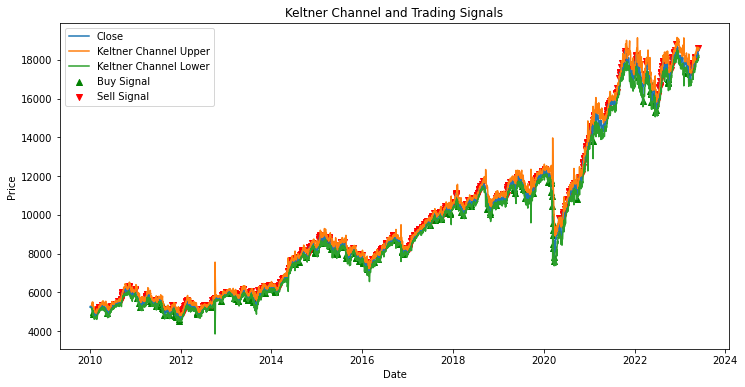

In [21]:
# Apply the optimized parameters
kc_timeperiod = best_parameters['kc_timeperiod']
bb_timeperiod = best_parameters['bb_timeperiod']
macd_fastperiod = best_parameters['macd_fastperiod']
macd_slowperiod = best_parameters['macd_slowperiod']
macd_signalperiod = best_parameters['macd_signalperiod']

# Calculate Keltner Channel with optimized parameters
nse['KC_Middle'] = nse['Close'].rolling(window=kc_timeperiod).mean()
nse['KC_ATR'] = nse['High'] - nse['Low']
nse['KC_Upper'] = nse['KC_Middle'] + (2 * nse['KC_ATR'])
nse['KC_Lower'] = nse['KC_Middle'] - (2 * nse['KC_ATR'])

# Calculate Bollinger Bands with optimized parameters
nse['BB_Middle'] = nse['Close'].rolling(window=bb_timeperiod).mean()
nse['BB_STD'] = nse['Close'].rolling(window=bb_timeperiod).std()
nse['BB_Upper'] = nse['BB_Middle'] + (2 * nse['BB_STD'])
nse['BB_Lower'] = nse['BB_Middle'] - (2 * nse['BB_STD'])

# Calculate MACD with optimized parameters
nse['MACD_Line'] = nse['Close'].ewm(span=macd_fastperiod).mean() - nse['Close'].ewm(span=macd_slowperiod).mean()
nse['MACD_Signal'] = nse['MACD_Line'].ewm(span=macd_signalperiod).mean()
nse['MACD_Hist'] = nse['MACD_Line'] - nse['MACD_Signal']

# Generate buy and sell signals
nse['Signal'] = 0
nse.loc[nse['Close'] > nse['KC_Upper'], 'Signal'] = -1  # Sell signal
nse.loc[nse['Close'] < nse['KC_Lower'], 'Signal'] = 1  # Buy signal

# Record the signals, dates, returns, and metrics
nse['Returns'] = nse['Close'].pct_change()
nse['Cumulative_Returns'] = (1 + nse['Returns']).cumprod()
nse['Trade_Returns'] = nse['Signal'].shift() * nse['Returns']
nse['Cumulative_Trade_Returns'] = (1 + nse['Trade_Returns']).cumprod()

# Print the generated signals and metrics
print(nse[['Close', 'KC_Upper', 'KC_Lower', 'Signal', 'Returns', 'Cumulative_Returns', 'Trade_Returns', 'Cumulative_Trade_Returns']])


# Plotting the indicators and signals
plt.figure(figsize=(12, 6))
plt.plot(nse['Close'], label='Close')
plt.plot(nse['KC_Upper'], label='Keltner Channel Upper')
plt.plot(nse['KC_Lower'], label='Keltner Channel Lower')

# Create a signal DataFrame with the same index as index_data
signal_data = pd.DataFrame(index=nse.index)
signal_data['Signal'] = 0
signal_data.loc[nse['Close'] > nse['KC_Upper'], 'Signal'] = -1  # Sell signal
signal_data.loc[nse['Close'] < nse['KC_Lower'], 'Signal'] = 1  # Buy signal

# Plot the signals at the corresponding dates
buy_signals = signal_data[signal_data['Signal'] == 1]
sell_signals = signal_data[signal_data['Signal'] == -1]
plt.scatter(buy_signals.index, nse.loc[buy_signals.index, 'Close'], color='green', marker='^', label='Buy Signal')
plt.scatter(sell_signals.index, nse.loc[sell_signals.index, 'Close'], color='red', marker='v', label='Sell Signal')

plt.legend()
plt.title('Keltner Channel and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()